# KÜTÜPHANELERİ YÜKLÜYORUZ

In [6]:
import pandas as pd, numpy as np, warnings, optuna, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import joblib
import os

In [7]:
warnings.filterwarnings("ignore")

*  VERİ SETİNİ YÜKLÜYORUZ

In [8]:
df = pd.read_excel("temizVeri_Bursa.xlsx")

In [9]:
df = df.drop(columns=["İl"])         # 'Bursa' sabit olduğu için çıkardık
df = df.dropna()                     # eksikleri atıyoruz
df = df[df["Fiyat"] < 35_000_000]    # Aykırı değerlerden kurtulmak için

* FEATURES ENGINEERING İLE VERİYİ DAHA ANLAMLI HALE GETİRİYORUZ

In [10]:
df["Toplam_Oda_Salon"] = df["Oda"] + df["Salon"]
df["Kullanim_Orani"]   = df["Net m2"] / df["Brüt m2"]
df["Kat_Orani"]        = df["Kat (Sayı)"] / df["Toplam Kat"]
df["Bina_Yasi_Log"]    = np.log1p(df["Bina Yaşı"])
df["m2_basi_fiyat"]    = df["Fiyat"] / df["Net m2"]

df["Fiyat_Log"] = np.log1p(df["Fiyat"])   # hedef log

In [11]:
print(df["m2_basi_fiyat"].mean())       # Arayüzde bu değeri kullacağımız için ne kadar olduğuna baktık

45167.88306205587


In [625]:
y = df["Fiyat_Log"]
X = df.drop(columns=["Fiyat", "Fiyat_Log"])

* ENCODİNG İŞLEMİ (TARGET ENC.)

In [626]:
cat_cols = ["Isıtma Tipi", "İlçe", "Mahalle", "Site İçinde mi?"]
num_cols = [c for c in X.columns if c not in cat_cols]

preprocess = ColumnTransformer([
    ("cat", TargetEncoder(), cat_cols),
    ("num", StandardScaler(), num_cols)
], remainder="passthrough")

###  Optuna ile Optimizasyon

Optuna, makine öğrenmesi modelleri için **hiperparametre optimizasyonu** sağlayan modern ve esnek bir kütüphanedir. Akıllı arama algoritmalarıyla en iyi parametre kombinasyonlarını otomatik olarak bulur. Böylece modelin doğruluğu artırılır, manuel deneme-yanılma süreci azaltılır.

Modelimiz için **en iyi parametreleri** bulmaya çalışıyoruz


In [627]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators",  300, 800),
        "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.15, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
        "objective": "reg:squarederror",
        "random_state": 42,
        "verbosity": 0
    }
    model = Pipeline([
        ("prep", preprocess),
        ("xgb",  XGBRegressor(**params))
    ])
    # 3-fold CV R² skoru
    cv_score = cross_val_score(model, X, y, cv=3, scoring="r2").mean()
    return cv_score


Optuna'yı 30 ilanda çalıştırarak bizim için en iyi parametreleri bulmasını sağlıyoruz 

In [628]:
study = optuna.create_study(direction="maximize", study_name="XGB_Bursa")
study.optimize(objective, n_trials=30, show_progress_bar=True)
print("🔧 En iyi parametreler:", study.best_params)

[I 2025-06-22 01:48:32,102] A new study created in memory with name: XGB_Bursa


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-06-22 01:48:32,959] Trial 0 finished with value: 0.9203622749839422 and parameters: {'n_estimators': 767, 'learning_rate': 0.03744672577187128, 'max_depth': 4, 'subsample': 0.8977189992069619, 'colsample_bytree': 0.7611699757344532, 'reg_lambda': 0.22793886443449324, 'reg_alpha': 4.496029922685688}. Best is trial 0 with value: 0.9203622749839422.
[I 2025-06-22 01:48:33,730] Trial 1 finished with value: 0.9124441449314439 and parameters: {'n_estimators': 596, 'learning_rate': 0.040183866981056006, 'max_depth': 5, 'subsample': 0.9868407020223576, 'colsample_bytree': 0.636039768048029, 'reg_lambda': 0.622598474217619, 'reg_alpha': 3.8265068751706357}. Best is trial 0 with value: 0.9203622749839422.
[I 2025-06-22 01:48:34,294] Trial 2 finished with value: 0.913540942577289 and parameters: {'n_estimators': 485, 'learning_rate': 0.1295474792214328, 'max_depth': 5, 'subsample': 0.7024313258581651, 'colsample_bytree': 0.9566801197363692, 'reg_lambda': 0.350577427210732, 'reg_alpha': 4.

***Optuna ile bulduğumuz parametrelerle XGBoost modelimizi oluşturup bir pipeline içine alıyoruz.***

In [629]:
best_xgb = XGBRegressor(**study.best_params)
final_pipe = Pipeline([
    ("prep", preprocess),
    ("xgb", best_xgb)
])

%80 Eğitim / %20 Test  olacak şekilde veri setini bölüyoruz

In [630]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
final_pipe.fit(X_train, y_train)

,steps,"[('prep', ...), ('xgb', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Modelin test verisi üzerindeki tahminlerini logaritmik formdan TL cinsine dönüştürüyoruz

In [631]:
y_pred_log = final_pipe.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

### Model Performansı 
Modelin test verisindeki performansı R²(Determinasyon Katsayısı), RMSE(Root Mean Squared Error) ve MAE(Mean Absolute Error) metrikleri 


In [632]:
r2  = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)

***Bu değerler ile modelimizin veriyi ne kadar iyi açıkladığını, tahmin hatalarının ortalamasını ve tahminler ile gerçek değerler arasındaki farkları görebiliyoruz***

In [633]:
print("-------------------------------------------------------------")
print(f" Test R² : {r2:.4f}")
print(f" Test RMSE: {rmse:,.0f} TL")
print(f" Test MAE : {mae:,.0f} TL")
print("-------------------------------------------------------------")

-------------------------------------------------------------
 Test R² : 0.9657
 Test RMSE: 685,451 TL
 Test MAE : 158,607 TL
-------------------------------------------------------------


***SON OLARAK GERÇEK DEĞERLER VE TAHMİN EDİLEN DEĞERLERİN GRAFİĞİNİ ÇİZİYORUZ***

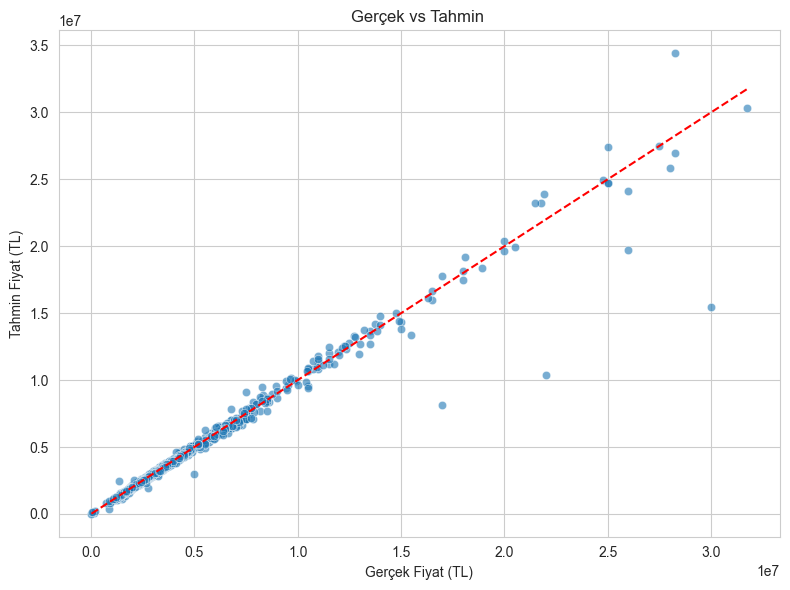

In [634]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("Gerçek Fiyat (TL)")
plt.ylabel("Tahmin Fiyat (TL)")
plt.title("Gerçek vs Tahmin ")
plt.tight_layout()
plt.show()     

TABLOYU İNCELEDİĞİMİZDE FİYATLAR ARTTIKÇA GERÇEK VE TAHMİN DEĞERLERİ ARASINDAKİ FARKLAR ARTMAYA BAŞLIYOR (Bu yüzden ***Fiyat*** sutünuna kısıtlama koymuştuk) ANCAK MODELİMİZİN GENEL PERFORMANSI İYİ GÖRÜNÜYOR. YİNE DE BAZI SAPMALAR MAE VE RMSE DEĞERLERİMİ YÜKSELTİYOR

In [635]:
joblib.dump(final_pipe, "XGBoost_model.pkl")
print("Model kaydedildi:", os.path.exists("XGBoost_model.pkl"))

Model kaydedildi: True
